In [22]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.0 MB/s eta 0:00:00


In [23]:
import datetime as dt
import pandas as pd
import io
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import shap
import xgboost as xgb

sns.set(style='darkgrid', context='talk', palette='Dark2')
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
uploaded = files.upload()

Saving full_features.csv to full_features.csv


In [7]:
dat = pd.read_csv('full_features.csv')
dat = dat.iloc[:, 1:]
df = dat.drop(['Adj Close','Close','High','Low','Symbol','weekly_price_change','Volume_y','Open_y','ticker','Volume_x'], axis=1)
df1 = df.copy()
df1 = df1.dropna(axis=0)



In [8]:
#one hot encode categorical variables for industry.....not including ticker at the moment but may in future iterations
def one_hot(df):
  encoder=OneHotEncoder(sparse=False)

  df_encoded = pd.DataFrame(encoder.fit_transform(df[['industry']]))

  df_encoded.columns = encoder.get_feature_names_out(['industry'])

  oh_df = pd.concat([df, df_encoded], axis=1)
  oh_df = oh_df.dropna()
  return oh_df

In [9]:
oh_df = one_hot(df1)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [10]:
train = oh_df[oh_df['Date'] <= '2023-06-01']
test = oh_df[oh_df['Date']>'2023-06-01']

In [11]:
test_y = test['target']
train_y = train['target']

test_x = test.drop(['target','Date','industry'],axis=1)
train_x = train.drop(['target','Date','industry'],axis=1)

scaler = MinMaxScaler()
# transform data
scaled_train_x = scaler.fit_transform(train_x)
scaled_test_x = scaler.transform(test_x)

In [14]:
#since I am using xgboost I will convert my data into DMatricies classes which are optimized for memory and speed
# https://www.datacamp.com/tutorial/xgboost-in-python
# https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d
# Create classification matrices
dtrain = xgb.DMatrix(scaled_train_x, train_y, enable_categorical=True)
dtest = xgb.DMatrix(scaled_test_x, test_y, enable_categorical=True)

In [17]:
# fit model no training data
model = xgb.XGBClassifier()
model.fit(scaled_train_x,train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [18]:
y_pred = model.predict(scaled_test_x)

accuracy = accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.48459958932238195
Precision: 0.41874462596732587
Recall: 0.5975460122699386


In [26]:
#set paramater grid
#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}
num_iterations = np.cumsum([len(x) for x in param_grid.values()])[-1]


Now I will tune hyper parameters via bayes search

In [27]:
bs_mod = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=num_iterations, scoring='accuracy', cv=3, return_train_score=True, verbose=3)


In [28]:
print(bs_mod)

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
              search_spaces={'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4,
                                       12.8, 25.6, 51.2, 102.4, 200],
                             'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2,
        

In [ ]:
bs_mod.fit(scaled_train_x, train_y)

In [30]:
best_params = {'gamma': 6.5,
              'learning_rate': 0.15,
              'max_depth': 14,
              'n_estimators': 80,
              'reg_alpha': 0.8,
              'reg_lambda': 0.1}

In [33]:
tuned = xgb.XGBClassifier(gamma=6.5,learning_rate=0.15,max_depth=14,n_estimators=80,reg_alpha=0.8,reg_lambda=0.1)
tuned.fit(scaled_train_x,train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=6.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [34]:
y_pred = tuned.predict(scaled_test_x)

accuracy = accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.4553388090349076
Precision: 0.40567484662576686
Recall: 0.649079754601227


In [35]:
explainer = shap.Explainer(tuned)


In [39]:
train_df = pd.DataFrame(scaled_train_x)
train_sample = train_df.sample(250)
cols = train_x.columns
train_sample.columns = cols

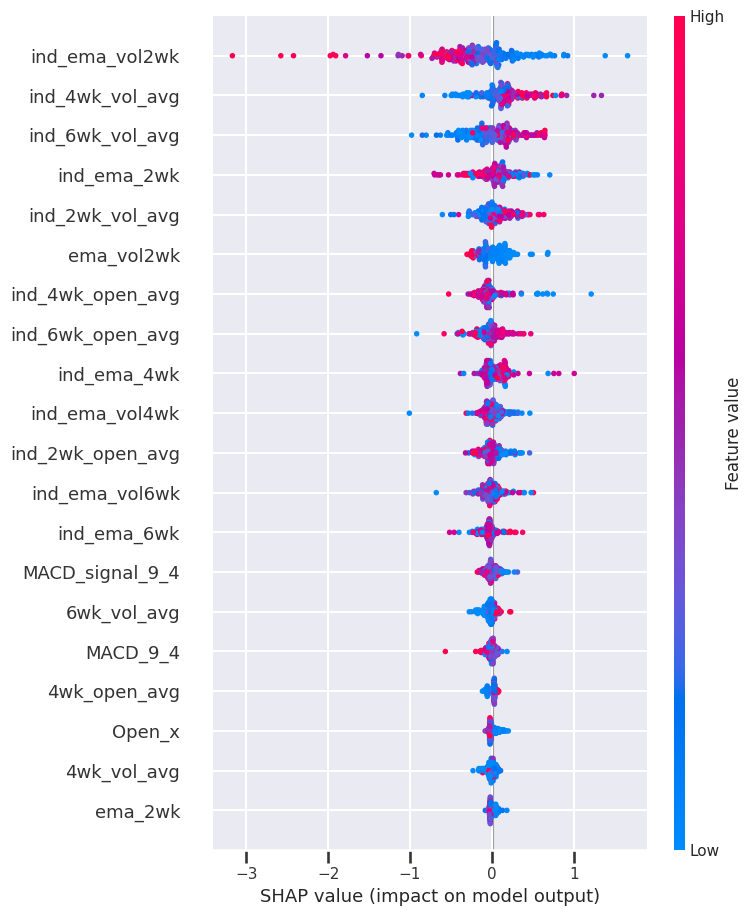

In [41]:
shap_values = explainer.shap_values(train_sample)
shap.summary_plot(shap_values, train_sample)

In [83]:
###simulation with NKE
oh = one_hot(dat)
oh_nke = oh[(oh['Date']>'2023-06-01')& (oh['Symbol']=='JPM')]
oh_nke = oh_nke.drop(['Adj Close','Close','High','Low','Symbol','weekly_price_change','Volume_y','Open_y','ticker','Volume_x','Date','industry'], axis=1)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [84]:
oh_nke.head()

,Open_x,target,2wk_open_avg,ema_2wk,4wk_open_avg,ema_4wk,6wk_open_avg,ema_6wk,2wk_vol_avg,ema_vol2wk,...,industry_Consumer Discretionary,industry_Consumer Staples,industry_Energy,industry_Financials,industry_Health Care,industry_Industrials,industry_Information Technology,industry_Materials,industry_Real Estate,industry_Utilities
46683,140.110001,1,138.455002,139.278847,138.045002,138.686057,138.655001,138.223853,44262550.0,4.355334e+07,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
46684,141.070007,1,140.590004,140.472954,139.745003,139.639637,138.456670,139.037040,44631050.0,4.619918e+07,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
46685,142.610001,0,141.840004,141.897652,140.147503,140.827783,139.310003,140.057886,42929950.0,4.095826e+07,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
46686,138.869995,0,140.739998,139.879214,140.665001,140.044668,140.076668,139.718489,46055900.0,4.950209e+07,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
nke_y = oh_nke['target']
nke_x = oh_nke.drop('target',axis=1)
x_scaled = scaler.transform(nke_x)

In [86]:
y_pred_nke = tuned.predict(x_scaled)

accuracy = accuracy_score(nke_y, y_pred_nke)
precision = precision_score(nke_y, y_pred_nke)
recall = recall_score(nke_y, y_pred_nke)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5
Precision: 0.5
Recall: 1.0


In [89]:
oh_nke['predicted'] = tuned.predict(x_scaled)

In [90]:
oh_nke.head()

,Open_x,target,2wk_open_avg,ema_2wk,4wk_open_avg,ema_4wk,6wk_open_avg,ema_6wk,2wk_vol_avg,ema_vol2wk,...,industry_Consumer Staples,industry_Energy,industry_Financials,industry_Health Care,industry_Industrials,industry_Information Technology,industry_Materials,industry_Real Estate,industry_Utilities,predicted
46683,140.110001,1,138.455002,139.278847,138.045002,138.686057,138.655001,138.223853,44262550.0,4.355334e+07,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
46684,141.070007,1,140.590004,140.472954,139.745003,139.639637,138.456670,139.037040,44631050.0,4.619918e+07,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
46685,142.610001,0,141.840004,141.897652,140.147503,140.827783,139.310003,140.057886,42929950.0,4.095826e+07,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
46686,138.869995,0,140.739998,139.879214,140.665001,140.044668,140.076668,139.718489,46055900.0,4.950209e+07,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
